In [1]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import unicodedata


from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Using NLTK

In [2]:
# Function to generate n-grams from sentences.
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]
 
data = 'A class is a blueprint for the object.'
 
print("1-gram: ", extract_ngrams(data, 1))
print("2-gram: ", extract_ngrams(data, 2))
print("3-gram: ", extract_ngrams(data, 3))
print("4-gram: ", extract_ngrams(data, 4))

1-gram:  ['A', 'class', 'is', 'a', 'blueprint', 'for', 'the', 'object', '.']
2-gram:  ['A class', 'class is', 'is a', 'a blueprint', 'blueprint for', 'for the', 'the object', 'object .']
3-gram:  ['A class is', 'class is a', 'is a blueprint', 'a blueprint for', 'blueprint for the', 'for the object', 'the object .']
4-gram:  ['A class is a', 'class is a blueprint', 'is a blueprint for', 'a blueprint for the', 'blueprint for the object', 'for the object .']


In [3]:
# load dataset
df = pd.read_csv('twitter_training.csv', header=None, usecols=[2,3])

In [4]:
# preview of dataset
df.head()

,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
# rename columns
df.columns = ['Sentiment', 'Text']

# remove missing values
df = df.dropna()

# encode target label
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

# establish input and output
X = list(df['Text'])
y = list(df['Sentiment'])

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Unigram

In [6]:
# create a bag of words for with unigrams and bigrams
cv = CountVectorizer(analyzer = 'word',ngram_range=(1,1), stop_words='english')

# convert training data to bag of words
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# train naive bayes classifier
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# create predictions
y_pred = clf.predict(X_test_cv)

# find f-1 score
score = f1_score(y_test, y_pred, average='micro')
print('F-1 score : {}'.format(np.round(score,4)))

F-1 score : 0.752


### Bigram

In [7]:
# create a bag of words for with unigrams and bigrams
cv = CountVectorizer(analyzer = 'word',ngram_range=(1,2), stop_words='english')

# convert training data to bag of words
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# train naive bayes classifier
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# create predictions
y_pred = clf.predict(X_test_cv)

# find f-1 score
score = f1_score(y_test, y_pred, average='micro')
print('F-1 score : {}'.format(np.round(score,4)))

F-1 score : 0.882


In [8]:
for N in range(1,11):
    
    # convert training data to bag of words
    cv = CountVectorizer(analyzer = 'word',ngram_range=(1,N), stop_words='english')
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)
    
    # train model and generate predictions
    clf = MultinomialNB()
    clf.fit(X_train_cv, y_train)
    y_pred = clf.predict(X_test_cv)
    
    # compute f-1 score
    score = np.round(f1_score(y_test, y_pred, average='micro'), 4)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N), score))

F-1 score of model with n-gram range of (1, 1): 0.752
F-1 score of model with n-gram range of (1, 2): 0.882
F-1 score of model with n-gram range of (1, 3): 0.8994
F-1 score of model with n-gram range of (1, 4): 0.9017
F-1 score of model with n-gram range of (1, 5): 0.9019
F-1 score of model with n-gram range of (1, 6): 0.9011
F-1 score of model with n-gram range of (1, 7): 0.9006
F-1 score of model with n-gram range of (1, 8): 0.9005
F-1 score of model with n-gram range of (1, 9): 0.9001
F-1 score of model with n-gram range of (1, 10): 0.8998


### Visualization

In [9]:
ADDITIONAL_STOPWORDS = ['_']

In [10]:
def basic_clean(text):
    """
    A simple function to clean up the data. All the words that are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
    
    words = re.sub(r'[^\w\s]', '', text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [11]:
words = basic_clean(''.join(str(df['Text'].tolist())))
words[:20]

['im',
 'getting',
 'borderland',
 'murder',
 'coming',
 'border',
 'kill',
 'im',
 'getting',
 'borderland',
 'kill',
 'im',
 'coming',
 'borderland',
 'murder',
 'im',
 'getting',
 'borderland',
 '2',
 'murder']

In [12]:
unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:10]

<AxesSubplot:>

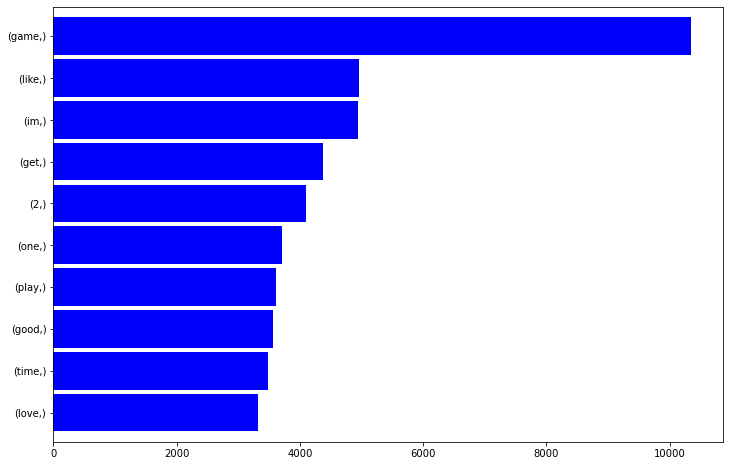

In [13]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

In [14]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
bigrams_series

(red, dead)               1492
(johnson, johnson)        1230
(dead, redemption)        1191
(home, depot)              985
(call, duty)               873
(assassin, creed)          813
(rhandlerr, rhandlerr)     780
(italy, italy)             769
(redemption, 2)            766
(cant, wait)               731
dtype: int64

<AxesSubplot:>

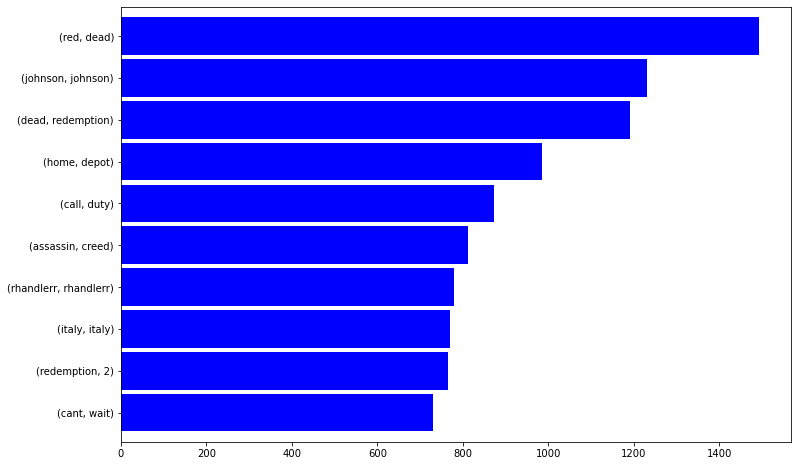

In [15]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

In [16]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
trigrams_series

(red, dead, redemption)              1116
(italy, italy, italy)                 761
(dead, redemption, 2)                 714
(xbox, series, x)                     561
(rhandlerr, rhandlerr, rhandlerr)     440
(access, health, care)                344
(ops, cold, war)                      303
(black, ops, cold)                    303
(occurred, see, detail)               295
(battlefield, 4, player)              286
dtype: int64

<AxesSubplot:>

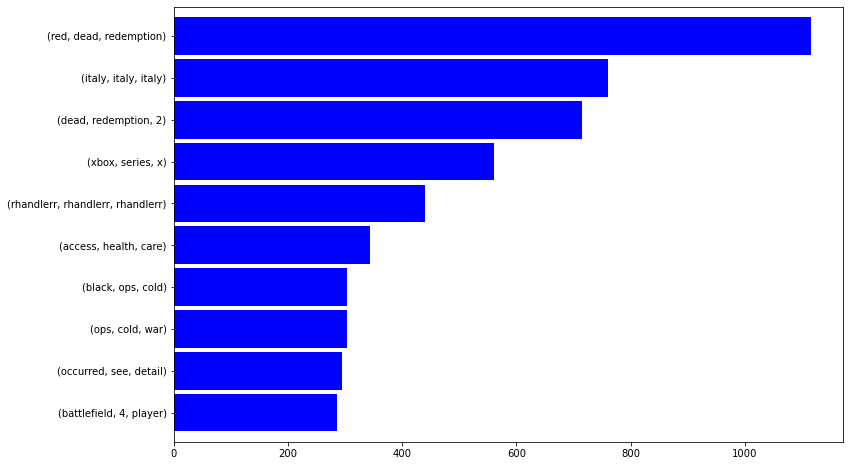

In [17]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))